In [665]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Input Parameters

## Stress State

In [666]:
GL = 4.03; WL = 0; 
g_sat = 20; g_unsat = 18; g_w = 10

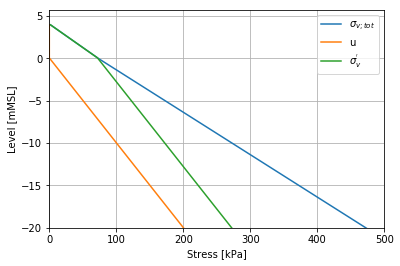

In [667]:
dz=0.1;
Depth = np.arange(dz,34.4,dz); Level = GL-Depth;
sigV = np.zeros(len(Depth));sigVTot = np.zeros(len(Depth)); u = np.zeros(len(Depth));
sigVTot[0] = g_unsat*dz
for i in np.arange(1,len(Depth),1):
    if Level[i]>WL:
        sigVTot[i] = sigVTot[i-1]+g_unsat*dz;
        u[i] = 0; 
    else:
        sigVTot[i] = sigVTot[i-1]+(g_sat)*dz;
        u[i] = u[i-1] + g_w*dz;
        
sigV = sigVTot - u;

plt.plot(sigVTot,Level,u,Level,sigV,Level)
plt.legend(['$\sigma_{v;tot}$','u','$\sigma_{v}^{\'}$']);
plt.ylabel('Level [mMSL]'); plt.xlabel('Stress [kPa]')
plt.xlim(0,500);plt.ylim(-20,);plt.grid();
plt.show();

## Seismic

In [668]:
amax_g = 0.24 ; Mw = 8.2 ; FS = 1.3

#qc-Dr correlation
C0 = 157; C1 = 0.55; C2 = 2.41; # Baldi NC
#C0 = 181; C1 = 0.55; C2 = 2.41; # Baldi OC/NC

# NCEER Method

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


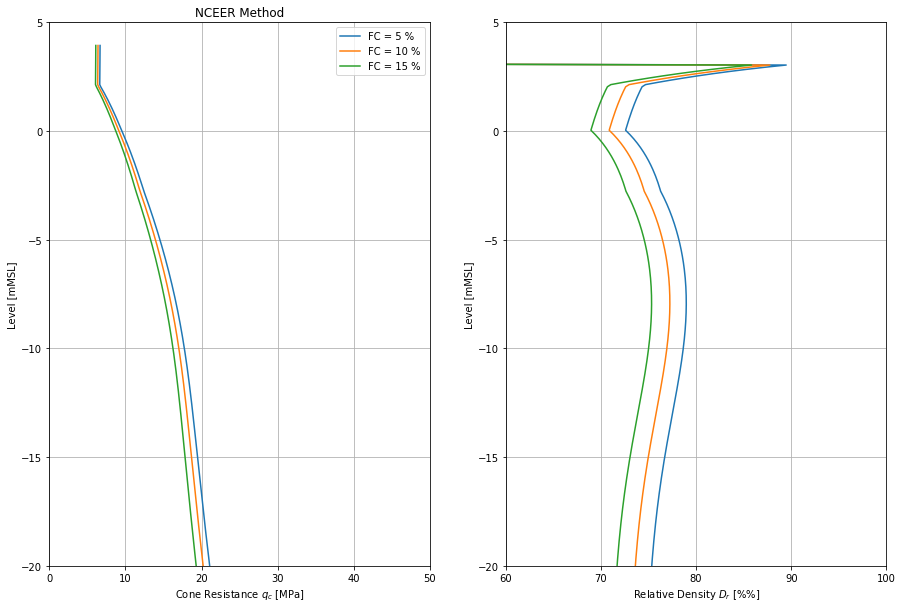

In [613]:
z = Depth;
#Idriss revised, 1995
MSF_id = 10**2.24/Mw**2.56
#Andrus and Stokoe, 1997
MSF_am = (Mw/7.5)**-2.56
MSF = max(MSF_id,MSF_am)

rd = np.clip((1-0.4113*z**0.5 + 0.04052*z + 0.001753*z**1.5) / (1 - 0.4177*z**0.5 + 0.05729*z - 0.006205*z**1.5 + 0.001210*z**2),0,1) #TF. Blake
CSR = 0.65*amax_g*np.divide(sigVTot,sigV)*rd; 
f = 0.7; Ksig = np.clip((sigV/100)**(f-1),0,1) #0.6-0.7 for Dr=60-80%, 0.7-0.8 for Dr=40-60%
CSR75 = CSR/(MSF*Ksig)
CRR75 = FS*CSR75
qc1Ncs = np.cbrt((CRR75 - 0.08)/93)*1000; #cubic root

#Ic = 2.6 #1.31 to 2.6 for sand15
#Kc = max(-0.403*Ic**4+5.581*Ic**3-21.63*Ic**2+33.75*Ic-17.88,1)
#qc1N = qc1Ncs/Kc

n = 0.5 #n=1 for clay, 0.5 for sand, 0.75 for silt/sandy silt/silty sand
Cq = np.clip((100/sigV)**n,0,1.7);
#qc = qc1N/Cq*100/1000

#FC = [5,10,15]; 
#alpha = np.zeros(3,); beta = alpha;
#for i in np.arange(0,3,1):
#    alpha[i] = np.exp(1.76-190/FC[i]**2)
#    beta[i] = 0.99+FC[i]**1.5/1000   
#alpha = np.clip(alpha, 0, 5)
#beta = np.clip(beta, 1, 1.2)
#qc_FC = alpha + beta*qc

#Yi, F., 2014, Estimating soil fines contents from CPT data
Ic5 = 1.59; Ic10 = (10-5)/(12-5)*(1.83-1.59)+1.59; Ic15 = (15-12)/(35-12)*(2.276-1.83)+1.83
Ic_FC = np.array([Ic5, Ic10, Ic15]); 

#Idriss and Boulanger, 2015
Ic_FC = (np.array([5,10,15])+137)/80;

Kc = np.clip(-0.403*Ic_FC**4+5.581*Ic_FC**3-21.63*Ic_FC**2+33.75*Ic_FC-17.88,1,100)
qc1N = np.zeros((len(sigV),len(Ic_FC))); qc = np.zeros((len(sigV),len(Ic_FC))); Dr = np.zeros((len(sigV),len(Ic_FC)))
plt.figure(figsize=(15,10)) 
for i in np.arange(0,len(Ic_FC),1):
    qc1N[:,i] = qc1Ncs/Kc[i]
    qc[:,i] = qc1N[:,i]/Cq*100/1000
    plt.subplot(121)
    plt.plot(qc[:,i],Level,label = 'FC = %.f %%' %FC[i])
    Dr[:,i] = (1/C2)*np.log(qc[:,i]*1000/(C0*(sigV)**C1))*100
    Dr[Depth<1,i] = 0
    plt.subplot(122)
    plt.plot(Dr[:,i],Level,label = 'FC = %.f %%' %FC[i])

 
plt.subplot(121);   
plt.title('NCEER Method')  
plt.ylabel('Level [mMSL]'); plt.xlabel('Cone Resistance $q_c$ [MPa]')
plt.grid(); plt.legend(); plt.xlim(0,50);plt.ylim(-20,5)
plt.subplot(122)
plt.ylabel('Level [mMSL]'); plt.xlabel('Relative Density $D_r$ [%%]')
plt.grid(); plt.xticks(np.arange(0, 110, step=10));plt.xlim(60,100);plt.ylim(-20,5); 

plt.show()

Nceer= pd.DataFrame()
Nceer['MSF'] = MSF*np.ones(len(sigV)); Nceer['Ksig'] = Ksig; Nceer['rd'] = rd;
Nceer['CSR75'] = CSR75; Nceer['CRR75'] = CRR75; Nceer['qc1Ncs'] = qc1Ncs; 
for i in np.arange(0,len(Ic_FC),1):
    Nceer['qc1N FC%.f%%' %FC[i]] = qc1N[:,i];
    Nceer['qc FC%.f%%' %FC[i]] = qc[:,i];

# Idriss and Boulanger

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


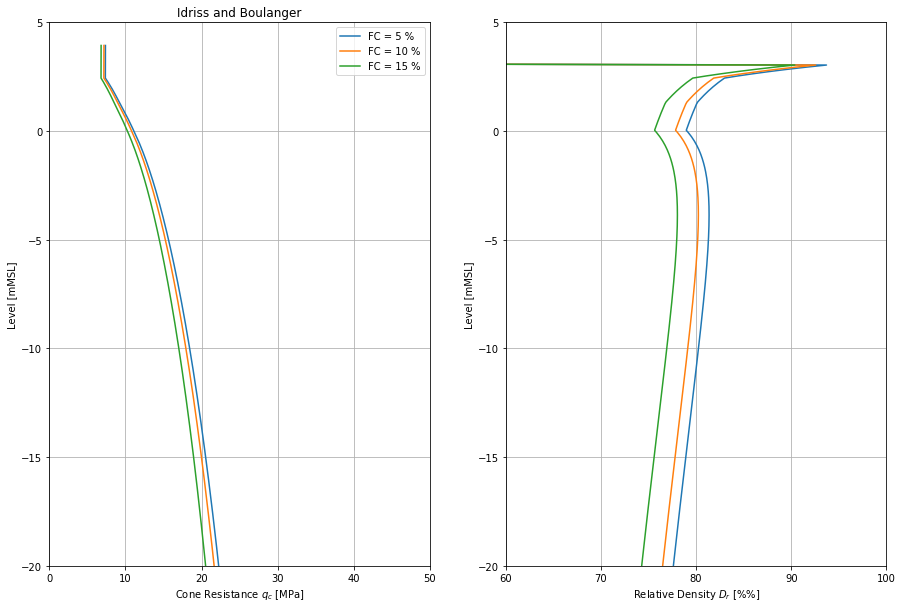

In [614]:
def correct_qc1Ncs(CRR75):
    #CRR = f(qc1Ncs^4) = f(ax^4+bx^3+cx^2+dx+e) --> solving system to derive qc1Ncs
    aa = (1/137)**4; bb = (-1/140)**3; cc = (1/1000)**2; dd = 1/113;
    ee = -2.8-np.log(CRR75)
    pp = (8*aa*cc - 3*bb**2) / (8*aa**2); qq = (bb**3 - 4*aa*bb*cc + 8*aa**2*dd)/(8*aa**3);
    Delta0 = cc**2-3*bb*dd + 12*aa*ee; Delta1 = 2*cc**3-9*bb*cc*dd+27*bb**2*ee+27*aa*dd**2-72*aa*cc*ee
    QQ = (0.5*(Delta1+(Delta1**2-4*Delta0**3)**0.5))**(1/3); SS = 0.5*(-2/3*pp+1/(3*aa)*(QQ+Delta0/QQ))**0.5
    qc1Ncs_correct = -bb/(4*aa) - SS + 0.5*(-4*SS**2 - 2*pp + qq/SS)**0.5
    return qc1Ncs_correct

#Idriss and Boulanger, 1999
MSF_idb = min(6.9*np.exp(-Mw/4)-0.058,1.8)
MSF = MSF_idb

rd = np.exp((-1.012-1.126*np.sin(z/11.73+5.133))+(0.106+0.118*np.sin(z/11.28+5.142))*Mw)
CSR = 0.65*amax_g*np.divide(sigVTot,sigV)*rd

qc1Ncs_0 = 100*np.ones(len(sigV)); #Initialization
Csig_0 = 1/(37.3-8.24*qc1Ncs_0**0.264); Csig_0 = np.clip(Csig_0,0,0.3)
Ksig_0 = 1-Csig_0*np.log(sigV/100); Ksig_0 = np.clip(Ksig_0,0,1.1)
CSR75_0 = CSR/(MSF*Ksig_0)
CRR75_0 = CSR75_0*FS
qc1Ncs_1 = correct_qc1Ncs(CRR75_0)

while max(np.abs(qc1Ncs_1-qc1Ncs_0)) > 0.001:
    qc1Ncs_0 = qc1Ncs_1
    Csig_0 = 1/(37.3-8.24*qc1Ncs_0**0.264); Csig_0 = np.clip(Csig_0,0,0.3)
    Ksig_0 = 1-Csig_0*np.log(sigV/100); Ksig_0 = np.clip(Ksig_0,0,1.1)
    CSR75_0 = CSR/(MSF*Ksig_0)
    CRR75_0 = CSR75_0*FS
    qc1Ncs_1 = correct_qc1Ncs(CRR75_0)
qc1Ncs = qc1Ncs_1;

m = 1.338 - 0.249*qc1Ncs**0.264
Cn = (100/sigV)**m; Cn = np.clip(Cn,0,1.7);

FC = np.arange(5,16,5);
qc1N = np.zeros((len(sigV),len(FC))); qc = np.zeros((len(sigV),len(FC))); Dr = np.zeros((len(sigV),len(FC)))
plt.figure(figsize=(15,10)) 
for i in np.arange(0,len(FC),1):
    qc1N[:,i] = (qc1Ncs-11.9) / (1+np.exp(1.63-(9.7/(FC[i]+2))-(15.7/(FC[i]+2))**2)/14.6)
    qc[:,i] = qc1N[:,i]*100/Cn/1000 #[MPa]
    plt.subplot(121)
    plt.plot(qc[:,i],Level,label = 'FC = %.f %%' %FC[i])
    Dr[:,i] = (1/C2)*np.log(qc[:,i]*1000/(C0*(sigV)**C1))*100
    Dr[Depth<1,i] = 0
    plt.subplot(122)
    plt.plot(Dr[:,i],Level,label = 'FC = %.f %%' %FC[i])

plt.subplot(121);   
plt.title('Idriss and Boulanger')  
plt.ylabel('Level [mMSL]'); plt.xlabel('Cone Resistance $q_c$ [MPa]')
plt.grid(); plt.legend(); plt.xlim(0,50);plt.ylim(-20,5)
plt.subplot(122)
plt.ylabel('Level [mMSL]'); plt.xlabel('Relative Density $D_r$ [%%]')
plt.grid(); plt.xticks(np.arange(0, 110, step=10));plt.xlim(60,100);plt.ylim(-20,5); 

plt.show()

IdBo = pd.DataFrame()
IdBo['MSF'] = MSF*np.ones(len(sigV)); IdBo['Ksig'] = Ksig_0; IdBo['rd'] = rd;
IdBo['CSR75'] = CSR75_0; IdBo['CRR75'] = CRR75_0; IdBo['qc1Ncs'] = qc1Ncs; 
for i in np.arange(0,len(Ic_FC),1):
    IdBo['qc1N FC%.f%%' %FC[i]] = qc1N[:,i];
    IdBo['qc FC%.f%%' %FC[i]] = qc[:,i];

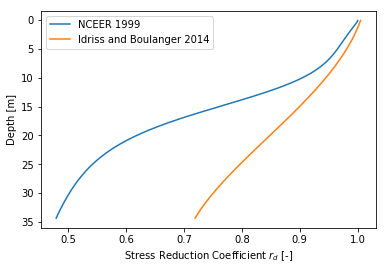

In [599]:
plt.plot(Nceer['rd'],z,IdBo['rd'],z)
plt.legend(['NCEER 1999','Idriss and Boulanger 2014']);plt.gca().invert_yaxis()
plt.ylabel('Depth [m]'); plt.xlabel('Stress Reduction Coefficient $r_d$ [-]')
plt.show()


# CPT criteria for evaluating Liquefaction Resistance
_[1] Youd, T. L., Idriss, I. M., Andrus, R. D., Arango, I., Castro, G., Christian, J. T., Dobry, R., Finn, W. D. L., Harder, L. F., Hynes, M. E., Ishihara, K., Koester, J. P., Liao, S. S. C., Marcuson, W. F., Martin, G. R., Mitchell, J. K., Moriwaki, Y., Power, M. S., Robertson, P. K., Seed, R. B., and Stokoe, K. H. (2001). Liquefaction resistance of soils: summary report from the 1996 NCEER and 1998 NCEER/NSF workshops on evaluation of liquefaction resistance of soils, J. Geotechnical and Geoenvironmental Eng., ASCE 127(10), 817–33.<br>
[2] Boulanger, R. W., and Idriss, I. M. (2014). CPT and SPT Based Liquefaction Triggering Procedures, Report No. UCD/CGN-14/01, Department of Civil & Environmental Engineering, College of Engineering, University of California at Davis_
## Graphs

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


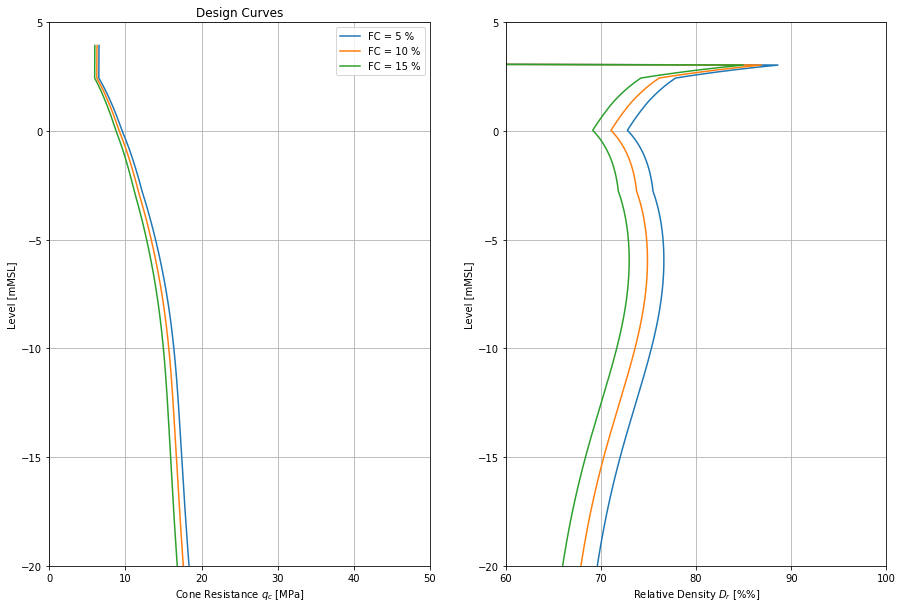

In [669]:
MSF_idb = min(6.9*np.exp(-Mw/4)-0.058,1.8)
MSF = MSF_idb

rd = np.clip((1-0.4113*z**0.5 + 0.04052*z + 0.001753*z**1.5) / (1 - 0.4177*z**0.5 + 0.05729*z - 0.006205*z**1.5 + 0.001210*z**2),0,1) #TF. Blake
CSR = 0.65*amax_g*np.divide(sigVTot,sigV)*rd; 
f = 0.7; Ksig = np.clip((sigV/100)**(f-1),0,1) #0.6-0.7 for Dr=60-80%, 0.7-0.8 for Dr=40-60%
CSR75 = CSR/(MSF*Ksig)
CRR75 = FS*CSR75
qc1Ncs = np.cbrt((CRR75 - 0.08)/93)*1000; #cubic root

m = 1.338 - 0.249*qc1Ncs_1**0.264
Cq = np.clip((100/sigV)**m,0,1.7);

Ic_FC = (np.array([5,10,15])+137)/80; #Idriss and Boulanger, 2015
Kc = np.clip(-0.403*Ic_FC**4+5.581*Ic_FC**3-21.63*Ic_FC**2+33.75*Ic_FC-17.88,1,100)
qc1N = np.zeros((len(sigV),len(Ic_FC))); qc = np.zeros((len(sigV),len(Ic_FC))); Dr = np.zeros((len(sigV),len(Ic_FC)))
plt.figure(figsize=(15,10)) 
for i in np.arange(0,len(Ic_FC),1):
    qc1N[:,i] = qc1Ncs/Kc[i]
    qc[:,i] = qc1N[:,i]/Cq*100/1000
    plt.subplot(121)
    plt.plot(qc[:,i],Level,label = 'FC = %.f %%' %FC[i])
    Dr[:,i] = (1/C2)*np.log(qc[:,i]*1000/(C0*(sigV)**C1))*100
    Dr[Depth<1,i] = 0
    plt.subplot(122)
    plt.plot(Dr[:,i],Level,label = 'FC = %.f %%' %FC[i])
 
plt.subplot(121);   
plt.title('Design Curves')  
plt.ylabel('Level [mMSL]'); plt.xlabel('Cone Resistance $q_c$ [MPa]')
plt.grid(); plt.legend(); plt.xlim(0,50);plt.ylim(-20,5)
plt.subplot(122)
plt.ylabel('Level [mMSL]'); plt.xlabel('Relative Density $D_r$ [%%]')
plt.grid(); plt.xticks(np.arange(0, 110, step=10));plt.xlim(60,100);plt.ylim(-20,5); 

plt.show()

Output = pd.DataFrame()
Output['rd'] = rd;
Output['CSR'] = CSR;
Output['Ksigma'] = Ksig;
Output['CSR75=CSR/(MSF*Ksigma)'] = CSR75;
Output['CRR75=FS*CSR75'] = CRR75;
Output['qc1Ncs'] = qc1Ncs;
Output['m'] = m;
Output['Cn'] = Cq;
Output['qc1N FC5%'] = qc1N[:,0];
Output['qc FC5%'] = qc[:,0]; 
Output['Dr FC5%'] = Dr[:,0]; 
Output['qc1N FC10%'] = qc1N[:,1];
Output['qc FC10%'] = qc[:,1];
Output['Dr FC10%'] = Dr[:,1];
Output['qc1N FC15%'] = qc1N[:,2];
Output['qc FC15%'] = qc[:,2];
Output['Dr FC15%'] = Dr[:,2];



### Summary Results qc Vs depth for several FC%

In [670]:
output = pd.DataFrame()
output['Levels'] = np.arange(0.0,-22.0,-2.0); 
output['FC5'] = np.zeros(len(output['Levels']));
output['FC10'] = np.zeros(len(output['Levels'])); 
output['FC15'] = np.zeros(len(output['Levels']))
k=0
for i in np.arange(0,-22,-2):
    output['FC5'][k] = qc[np.round(Level,1)==i,0]
    output['FC10'][k] = qc[np.round(Level,1)==i,1]
    output['FC15'][k] = qc[np.round(Level,1)==i,2]
    k = k+1;
    
round(output,2)

,Levels,FC5,FC10,FC15
0,0.0,9.53,9.14,8.73
1,-2.0,11.55,11.08,10.58
2,-4.0,13.20,12.66,12.09
3,-6.0,14.59,14.00,13.36
4,-8.0,15.63,15.00,14.32
5,-10.0,16.36,15.69,14.98
6,-12.0,16.85,16.16,15.43
7,-14.0,17.22,16.52,15.77
8,-16.0,17.57,16.85,16.09
9,-18.0,17.94,17.21,16.43


In [671]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(Output)

           rd       CSR    Ksigma  CSR75=CSR/(MSF*Ksigma)  CRR75=FS*CSR75  \
0    1.000000  0.156000  1.000000                0.187890        0.244258   
1    1.000000  0.156000  1.000000                0.187890        0.244258   
2    0.999585  0.155935  1.000000                0.187813        0.244156   
3    0.998890  0.155827  1.000000                0.187682        0.243987   
4    0.998156  0.155712  1.000000                0.187544        0.243807   
5    0.997400  0.155594  1.000000                0.187402        0.243623   
6    0.996631  0.155474  1.000000                0.187257        0.243435   
7    0.995854  0.155353  1.000000                0.187112        0.243245   
8    0.995074  0.155232  1.000000                0.186965        0.243054   
9    0.994292  0.155110  1.000000                0.186818        0.242864   
10   0.993512  0.154988  1.000000                0.186671        0.242673   
11   0.992734  0.154866  1.000000                0.186525        0.242483   

# $V_{s}$ criteria for evaluating Liquefaction Resistance

In [ ]:
Vs1 = Vs*(100/sigV)**0.25